In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# packages for interactive plotting display
from IPython import display
import time

In [1]:
# Construct a 2D lennard jones fluid to experiment with
# Everything in lennard jones units (equilibrium distance and energy)
# NOTE: 2D volumes are actually areas V=L**2

In [3]:
# lennard jones energy
def calc_pair_energy(dist_a):
    # NaNs are used to represent the distance between an atom and itself
    E_a = dist_a**-12 - 2* dist_a**-6
    
    # Replace any NaNs with zero energy (ignore self-interaction energy)
    E_a[np.isnan(dist_a)] = 0.0
    return E_a

In [4]:
def min_img_dist(pos0_a,pos1_a,L):
    Ndim = 2
    dx_a = np.zeros(Ndim)
    for ind in range(Ndim):
        ix0 = pos0_a[ind]
        ix1 = pos1_a[ind]
        
        idx = ix0 - ix1
        #  BUG FOUND: need to properly handle periodic boundary conditions
        if idx > L/2:
            idx = idx - L
        if idx < -L/2:
            idx = idx + L
            
        dx_a[ind] = idx 
        
    dist = np.sqrt(np.sum(dx_a**2))
    # dist2 = 0
    # for ind in range(Ndim):
    #     dist2 += dx_a[ind]**2
    #     
    # dist = np.sqrt(dist2)
    return dist

def calc_pair_dist(iatom, pos_a, L, ipos_a=None):
    if ipos_a is None:
        ipos_a = pos_a[iatom]
        
    N = pos_a.shape[0]
    dist_a = np.zeros(N)
    
    for j in range(N):
        ijdist = min_img_dist(ipos_a,pos_a[j],L)
        # BUG FOUND: Need to check if iatom and j are the same atom
        #    NOT if the distance is zero
        if j==iatom:
            ijdist = np.nan
            
        dist_a[j] = ijdist
        
    return dist_a
        

In [5]:
# Metropolis-Hastings acceptance criteria
def metro_accept( dE_kT ):
    paccept = np.exp( - dE_kT )
    pdraw = np.random.rand(1)
    
    if pdraw <= paccept:
        accept = True
    else:
        accept = False
        
    return accept


In [6]:

# Test to see that results are reasonable
metro_test_a = []
for ind in range(10):
    metro_test_a.append([metro_accept(.1),metro_accept(.3), metro_accept(1), metro_accept(3)])
    
metro_test_a = np.array(metro_test_a)

print('Metropolis-Hastings Test')
print('---')
print('         dE/kT      ')
print('  0.1,  0.3,   1.0,   3.0')
print(metro_test_a)
            

Metropolis-Hastings Test
---
         dE/kT      
  0.1,  0.3,   1.0,   3.0
[[ True False False False]
 [ True  True False False]
 [ True  True False False]
 [ True  True False False]
 [False  True  True False]
 [ True False  True False]
 [ True  True  True False]
 [ True  True False False]
 [ True  True  True False]
 [False  True  True  True]]


In [7]:
# Start simulation

In [8]:
N = 30 # number of atoms
rho = 3.0 # number density of atoms
kT = 0.001

V = N*(1/rho)
L = V**(1/2)  # 2D volumes are really areas...

In [9]:
# Consider ideal gas without any interaction energies

array([        nan,  0.13003404,  1.27919802,  0.81772954,  0.7425795 ,
        1.03208732,  1.11782002,  1.6884302 ,  1.21400965,  1.55611938,
        0.28077695,  0.87248648,  1.95008753,  0.89956127,  0.52669349,
        1.38348594,  0.7642816 ,  0.53328319,  1.60099999,  0.26363788,
        1.14150921,  1.03977   ,  1.60292929,  1.70358906,  1.10053294,
        0.19376737,  1.49383427,  0.42421684,  1.7777609 ,  0.06641703])

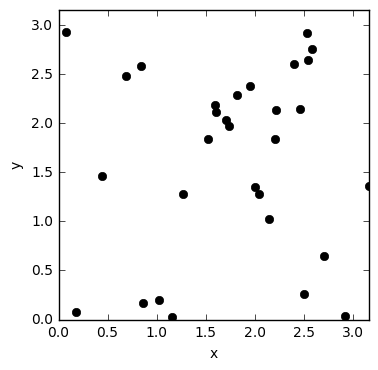

In [10]:
# Choose initial random positions and plot
#  pos_a = L/2*np.random.rand(N,2)
pos_a = L*np.random.rand(N,2)


# Plot config
plt.plot(pos_a[:,0],pos_a[:,1],'ko')
plt.xlim(0,L)
plt.ylim(0,L)

plt.axes().set_aspect('equal') # make sure it plots as a square
plt.xlabel('x')
plt.ylabel('y')

iatom = 0
ipos_curr_a = pos_a[iatom]
calc_pair_dist(iatom, pos_a, L, ipos_a=ipos_curr_a)


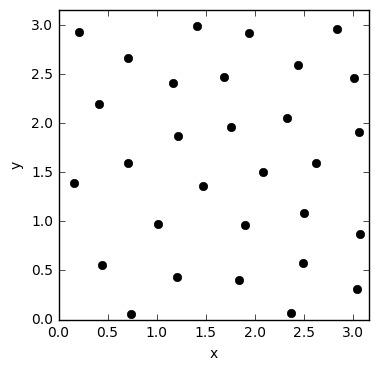

In [11]:
# Consider random alterations to atomic positions
show = True
# show = False
Nsweep = 100
dr_avg = (1/rho)**(1/2)
# dr_step = 0.1*dr_avg
dr_step = 0.03*dr_avg

for indsweep in range(Nsweep):
    for iatom in range(N):
        # Generate random step from normal distribution
        ipos_curr_a = pos_a[iatom]
        dpos_step_a = dr_step*np.random.randn(2)
        ipos_prop_a = ipos_curr_a + dpos_step_a 
        # Ensure that the atoms lie within the simulation cell wrapping across edges of the box
        # Use modulo function
        ipos_prop_a = np.mod( ipos_prop_a ,L)
        
        idist_pos_curr_a = calc_pair_dist(iatom, pos_a, L, ipos_a=ipos_curr_a)
        idist_pos_prop_a = calc_pair_dist(iatom, pos_a, L, ipos_a=ipos_prop_a)
        
        iE_pos_curr_a = calc_pair_energy(idist_pos_curr_a)
        iE_pos_prop_a = calc_pair_energy(idist_pos_prop_a)
        
        dE = np.sum(iE_pos_prop_a- iE_pos_curr_a)
        dE_kT = dE/kT
        # print(dE_kT)
        # print(iE_pos_prop_a- iE_pos_curr_a)
        # print(idist_pos_curr_a)
        
        accept = metro_accept(dE_kT)
        
        if accept:
            pos_a[iatom] = ipos_prop_a # stores new position if it's accepted. NOT FULLY SURE ASK!!
        #else:
        #   ipos_prop_a = ipos_prop_a # leaves position unchanged if it's rejected. 
        
        # for ideal gas, always accept proposal, since Epair = 0 for ideal gas
        # pos_a[iatom] = ipos_prop_a
        
    if show:
        plt.cla()
        plt.plot(pos_a[:,0],pos_a[:,1],'ko')
        plt.xlim(0,L)
        plt.ylim(0,L)
    
        plt.axes().set_aspect('equal') # make sure it plots as a square
        plt.xlabel('x')
        plt.ylabel('y')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(.001)
    

In [ ]:
# Steps to create Monte Carlo atomic simulation code for lennard jones
# 0) Copy code from above for ideal gas atomic position changes
# 1) Calculate pair distances for current and proposed states(using calc_pair_dist function)
# 2) Use metro-acceptance function to determine whether to accept or reject proposal
# 3) If accept, store new position, otherwise leave unchanged

# Run code (with plotting commands, to show how atomic positions evolve with Lennard Jones
# interactions model


In [ ]:
# Now update code to store changes in energy and position as system evolves
# 0) define new pos_hist_a and Etot_hist_a arrays, as well as current energy variable Etot
# 1) begin by calculating energy of initial position array
# 2) Begin monte carlo for loop. Every time proposal is accepted, update energy variable
# 3) At the end of each sweep (through every atom in the box), store pos_a and Etot 
#    in pos_hist_a and Etot_hist_a
#
# 4) After monte carlo simulation, plot how total energy evolves during simulation
#     -> it should generally decrease until the system reaches equilibrium, where it will then
#        randomly fluctuate around an average value
# 5) Calculate the average nearest neighbor distance for each snapshot, and then plot how it 
#      evolves during the simulation
#     -> the average distance should aproach a value near the equilibrium value